In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import tensorflow.keras as keras

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)
SEED = 1024


Segmentation Models: using `keras` framework.


In [3]:
def get_seagull_path(istrain=True):
    directory = "C:\Alans\seagull"

    if istrain:
        trainimg = os.path.join(directory, "trainimg", "*.jpg")
        images = glob.glob(trainimg, recursive=True)
        trainmask = os.path.join(directory, "trainmask", "*.jpg")
        labels = glob.glob(trainmask, recursive=True)
    else:
        testimg = os.path.join(directory, "testimg", "*.jpg")
        images = glob.glob(testimg, recursive=True)
        testmask = os.path.join(directory, "testmask", "*.jpg")
        labels = glob.glob(testmask, recursive=True)

    print(len(images), len(labels))

    mask_set = set()
    image_set = set()
    for lbl in labels:
        lbl = lbl.split('\\')[-1]
        mask_set.add(lbl)

    for img in images:
        img = img.split('\\')[-1]
        image_set.add(img)

    complete_path = mask_set.intersection(image_set)
    print(
        f"IMG - LBL NUM: {len(image_set.difference(mask_set))}, Intersection: {len(complete_path)}"
    )

    return [i for i in complete_path]

def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


def path_2_test(path):
    return (
        r"C:\Alans\seagull\\testimg\\" + path,
        r"C:\Alans\seagull\\testmask\\" + path,
    )


def path_2_train(path):
    return (
        r"C:\Alans\seagull\trainimg\\" + path,
        r"C:\Alans\seagull\trainmask\\" + path,
    )


def get_mask(image, label):
    labels = []
    labels.append(label[:, :, 0] == 0)
    labels.append(label[:, :, 0] == 255)

    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, ratio=0.8):
    AUTOTUNE = tf.data.AUTOTUNE

    paths = get_seagull_path()
    ds1 = tf.data.Dataset.from_tensor_slices(paths)
    ds1 = ds1.map(path_2_train, AUTOTUNE)

    paths = get_seagull_path(False)
    ds2 = tf.data.Dataset.from_tensor_slices(paths)
    ds2 = ds2.map(path_2_test, AUTOTUNE)

    ds = ds1.concatenate(ds2)
    ds = ds.cache()

    takefortrain = int(23124 * ratio)
    trainds = ds.take(takefortrain)
    testds = ds.skip(takefortrain).take(23124 - takefortrain)

    trainds = trainds.shuffle(23124)

    trainds = trainds.map(get_image_decode, AUTOTUNE)
    trainds = trainds.map(get_mask, AUTOTUNE)
    testds = testds.map(get_image_decode, AUTOTUNE)
    testds = testds.map(get_mask, AUTOTUNE)

    # # batch and prefetch
    trainds = trainds.batch(batch_size)
    testds = testds.batch(batch_size)

    trainds = trainds.prefetch(AUTOTUNE)

    return trainds, testds



In [4]:
def create_backbone_efficient():
    _backbone = keras.applications.EfficientNetB0(input_shape=(256, 256, 3), include_top=False)

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )

In [5]:
class FPN(tf.keras.layers.Layer):
    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone_efficient()

        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=False)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)

        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN(backbone)
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all

class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone_efficient()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=n_classes,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=n_classes,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_3 = tf.keras.layers.Convolution2DTranspose(
            filters=n_classes,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_4 = tf.keras.layers.Convolution2DTranspose(
            filters=n_classes,
            kernel_size=(4, 4),
            strides=(4, 4),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv1_o, conv2_o, conv3_o, conv4_o = self.backbone(images, training=False)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv4_o) + conv3_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv2_o
        fcn_4x = self.upscale2x_3(fcn_8x) + conv1_o
        final_output = self.upscale2x_4(fcn_4x)
        final_output = self.final_activation(final_output)
        return final_output



In [6]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred, showPerChannel=False):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    if showPerChannel:
        return (intersection + 0.1) / (union + 0.1)
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


In [7]:
def eval_model(model, trainds, testds, isUnet):
    # evaluate on training set
    iteration = 0
    iou = tf.zeros([2])
    for bs_images, bs_label in trainds:
        if isUnet:
            bs_images = sm.get_preprocessing("efficientnetb0")(bs_images)

        if isUnet:
            output = model(bs_images, training=True)
        else:
            output = model(bs_images, training=False)
        iou += Jindex(bs_label, output, showPerChannel=True)
        iteration += 1
    train_iou = iou / iteration

    # evaluate on test set
    iteration = 0
    iou = tf.zeros([2])
    for bs_images, bs_label in testds:
        if isUnet:
            bs_images = sm.get_preprocessing("efficientnetb0")(bs_images)

        if isUnet:
            output = model(bs_images, training=True)
        else:
            output = model(bs_images, training=False)
        iou += Jindex(bs_label, output, showPerChannel=True)
        iteration += 1
    test_iou = iou / iteration

    print(f"Train IoU: {train_iou} | Train IoU: {test_iou}")

    return train_iou, test_iou

# Testing starts below


In [8]:
n_classes = 2
batch_size = 32
trainds, testds = create_ds(batch_size)
iou_list = []

19373 17243
IMG - LBL NUM: 10687, Intersection: 8686
14476 14443
IMG - LBL NUM: 38, Intersection: 14438


In [9]:
####################################
# FCN8s
####################################
name = "fcn8s"
model = FCN_ORIG(n_classes)

ckpt = tf.train.Checkpoint(model=model)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model_seagull/fcn8s", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds, False)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model

Train IoU: [0.9655383  0.02255749] | Train IoU: [0.96391547 0.03263768]


In [10]:
####################################
# UNET
####################################
name = "unet"
model = sm.Unet(
    backbone_name="efficientnetb0",
    encoder_weights="imagenet",
    encoder_freeze=False,
    activation="softmax",
    classes=n_classes,
    decoder_use_batchnorm=False,
)

ckpt = tf.train.Checkpoint(model=model)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model_seagull/unet", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds, True)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model

Train IoU: [0.99849415 0.652435  ] | Train IoU: [0.9976776  0.65111434]


In [17]:
####################################
# FPN
####################################
name = "fpn"
model = FCN(n_classes)

ckpt = tf.train.Checkpoint(model=model)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model_seagull/fpn", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds, False)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model

Train IoU: [0.99855494 0.68339324] | Train IoU: [0.9977858 0.6819999]


In [14]:
def convert(x):
    return np.concatenate([[x[0]], x[1].numpy(), x[2].numpy()])


In [22]:
results = pd.DataFrame(
    list(map(convert, iou_list)),
    columns=[
        "model",
        "trainc1",
        "trainc2",
        "testc1",
        "testc2",
    ],
)

results.to_csv('results_seagull.csv')
second = results.pop("model")

results.iloc[:, 0:] = results.iloc[:, 0:].astype("float")
results["model"] = second
results


,trainc1,trainc2,testc1,testc2,model
0,0.965538,0.022557,0.963915,0.032638,fcn8s
1,0.998494,0.652435,0.997678,0.651114,unet
2,0.998555,0.683393,0.997786,0.682000,fpn


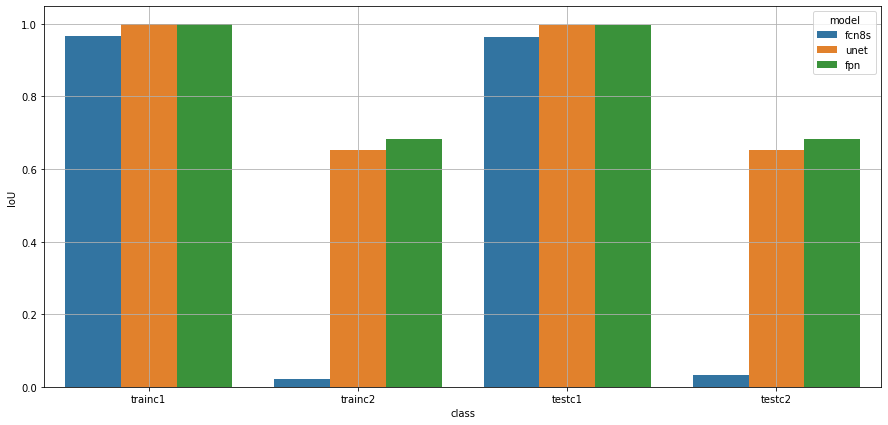

In [23]:
fg, ax = plt.subplots(figsize=(15, 7))
sb.barplot(
    data=results.melt(id_vars="model").drop_duplicates(),
    y="value",
    x="variable",
    hue="model",
    ax=ax,
)
ax.set_xlabel("class")
ax.set_ylabel("IoU")
ax.grid()